# Elastic Vigh formulation 


# Forward modeling

Partindo da equação 2D elastica de primeira ordem do tipo: 

\begin{equation}
\left\{\begin{array}{ll} 
\dfrac{\partial \sigma_{xx}}{\partial t} - (\lambda+2\mu)\dfrac{\partial v_{x}}{\partial x}-\lambda\dfrac{\partial v_{z}}{\partial z}=f_{\sigma_{xx}},\\
%
\dfrac{\partial\sigma_{zz}}{\partial t}-(\lambda+2\mu)\dfrac{\partial v_{z}}{\partial z} -\lambda\dfrac{\partial v_{x}}{\partial x}=f_{\sigma_{zz}},\\
%
\dfrac{\partial \sigma_{zx}}{\partial t} -\mu\Big(\dfrac{\partial v_{x}}{\partial z} + \dfrac{\partial v_{z}}{\partial x}\Big) = f_{\sigma_{zx}},\\
%
\rho\dfrac{\partial v_x}{\partial t} - \Big(\dfrac{\partial \sigma_{xx}}{\partial x} + \dfrac{\partial \sigma_{xz}}{\partial z} )=0,\\
%
\rho\dfrac{\partial v_z}{\partial t} - \Big(\dfrac{\partial \sigma_{zx}}{\partial x}+\dfrac{\partial \sigma_{zz}}{\partial z}\Big)=0 .
%
\end{array}\right.
\end{equation}

que na forma matricial é do tipo 


\begin{equation}
     \left\{\begin{array}{l}\rho \dfrac{\partial \vec{v}}{\partial t}-D \sigma=0,\\ 
     \dfrac{\partial \sigma}{\partial t}-C D^{T} \vec{v}=f_\sigma, \end{array}\right.
\end{equation}


onde $\vec{v}=(v_x,~v_z)$  são os campos do vetor velocidade de partícula horizontal e vertical, $\sigma=(\sigma_{xx},~\sigma_{zz},~\sigma_{xz}$) são os campos de stress,

\begin{equation}
\begin{split}
   C=\left(\begin{array}{ccc}
   \lambda+2 \mu & \lambda & 0 \\
   \lambda & \lambda+2 \mu & 0 \\ 
   0 & 0 & \mu \end{array}\right)~~\text{e}~~
D=\left(\begin{array}{ccc}  
\dfrac{\partial}{\partial x}& 0 &\dfrac{\partial}{\partial z} \\
0 &  \dfrac{\partial}{\partial z}&\dfrac{\partial}{\partial x}
\end{array}\right)  .
\end{split}
\end{equation}

Na formulação convencional, utilizada pelo devito oficial, o tensor de stress $\tau$ é uma matriz do tipo: 

\begin{equation}
\tau=\left(\begin{array}{cc}
 \tau_{xx}  &  \tau_{xz} \\
 \tau_{zx} &   \tau_{zz}
\end{array}\right)
\end{equation}

Já na formulação deste tutorial, o tensor de stress é representado por $\sigma$ e é escrito na forma vetorial: 

\begin{equation}
\sigma=\left(\begin{array}{c}
 \sigma_{xx}  \\ 
 \sigma_{zz}  \\ 
 \sigma_{zx}
\end{array}\right)
\end{equation}

a opção para setar o tensor de stress na forma vetorial é atravez do parametro `vec`=<span style="color:green">**True**</span>, tal detalhe será mais discutido a frente. 



In [24]:
import numpy as np
import sympy as sp

import matplotlib.pyplot as plt
from devito import configuration
configuration['log-level'] = 'WARNING'

from devito import *
from examples.seismic.source import RickerSource, WaveletSource, TimeAxis
from examples.seismic import Model, plot_image, setup_geometry, PointSource
from examples.seismic import demo_model, SeismicModel, plot_velocity, plot_perturbation
from examples.seismic.elastic.operators import create_matrix
from devito import div, D, S

In [25]:
nx = 425
nz = 200

shape=(nx, nz)
origin=(0., 0.)
sp = (10., 10.)
dtype = np.float32
so=16

nbl = 50

vp = np.empty(shape, dtype=dtype)
vs = np.empty(shape, dtype=dtype)
rho = np.empty(shape, dtype=dtype)
b = np.empty(shape, dtype=dtype)

path="/home/projeto-lde/dados/elastic/Mamousi_elastic/model/segmented/"

name="Marmo_elas_vp_frame1_10x10.bin"
a = open(path+name, "rb")
vp = np.fromfile(a, dtype=dtype, count=nx*nz).reshape([nx, nz])
vp = vp/1000.
a.close()

name="Marmo_elas_vs_frame2_10x10.bin"
a = open(path+name, "rb")
vs = np.fromfile(a, dtype=dtype, count=nx*nz).reshape([nx, nz])
vs = vs/1000.
a.close()

name="Marmo_elas_rho_frame3_10x10.bin"
a = open(path + name, "rb")
rho = np.fromfile(a, dtype=dtype, count=nx*nz).reshape([nx, nz])
a.close()

b[:] = 1./rho[:]

In [26]:
model_marmo = SeismicModel(vp=vp, vs=vs, b=b, origin=origin, space_order=so, shape=shape, dtype=dtype, 
                     spacing=sp, nbl=nbl)

In [27]:
def img_model(img1, img2, img3, model, title=""):

    aspect_ratio = model.shape[0]/model.shape[1]

    plt_options_model = {'cmap': 'jet', 'extent': [model.origin[0], model.origin[0] + model.domain_size[0],
                                                   model.origin[1] + model.domain_size[1], model.origin[1]]}
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 5))

    scale1 = np.max(img1) 
    scale2 = np.min(img1) 

    imag1 = ax[0].imshow(np.transpose(img1), vmin=scale1, vmax=scale2, **plt_options_model)
    fig.colorbar(imag1, ax=ax[0])
    ax[0].set_title("Vp (km/s)", fontsize=20)
    ax[0].set_xlabel('z (m)', fontsize=20)
    ax[0].set_ylabel('x (m)', fontsize=20)
    ax[0].set_aspect('auto')
    
    scale3 = np.max(img2) 
    scale4 = np.min(img2) 
    
    imag2 = ax[1].imshow(np.transpose(img2), vmin=scale3, vmax=scale4, **plt_options_model)
    fig.colorbar(imag2, ax=ax[1])
    ax[1].set_title("Vs (km/s)", fontsize=20)
    ax[1].set_xlabel('z (m)', fontsize=20)
    ax[1].set_ylabel('x (m)', fontsize=20)
    ax[1].set_aspect('auto')

    scale5 = np.max(img3) 
    scale6 = np.min(img3) 
    
    imag3 = ax[2].imshow(np.transpose(img3), vmin=scale5, vmax=scale6, **plt_options_model)
    fig.colorbar(imag3, ax=ax[2])
    ax[2].set_title(r"$\rho$ ($g/cm^3$)", fontsize=20)
    ax[2].set_xlabel('z (m)', fontsize=20)
    ax[2].set_ylabel('x (m)', fontsize=20)
    ax[2].set_aspect('auto')
    
    

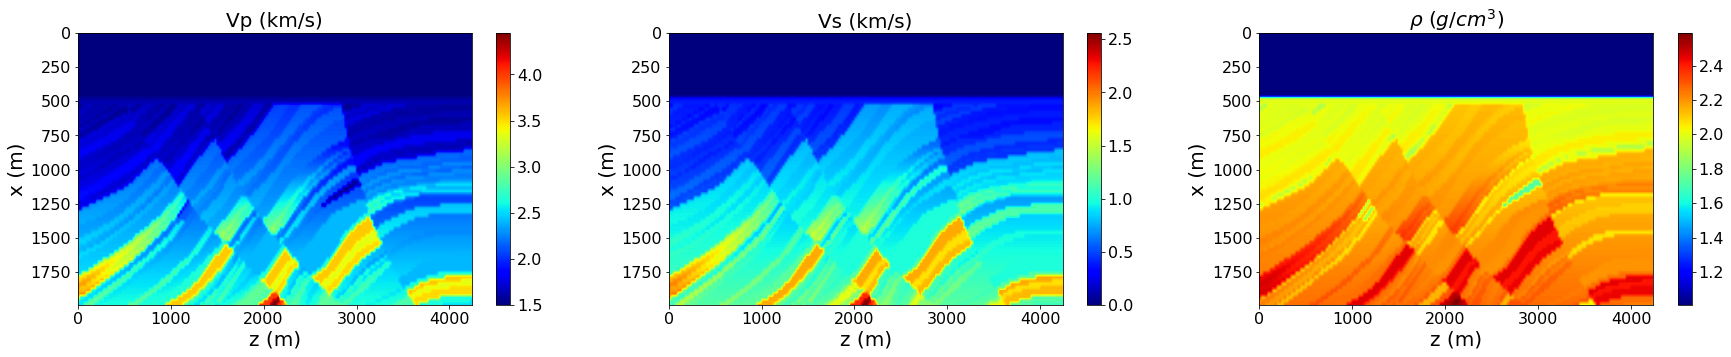

In [28]:
img_model(vp, vs, rho, model_marmo)

In [52]:
f0 = 0.020 # peak/dominant frequency 
b = model_marmo.b
rho = 1./b

s = model_marmo.grid.stepping_dim.spacing
damp = model_marmo.damp

# Time step in ms and time range:
t0, tn = 0., 4000.

dt = model_marmo.critical_dt * 0.5

time_range = TimeAxis(start=t0, stop=tn, step=dt)

geometry = setup_geometry(model_marmo, tn, f0=f0)
geometry.resample(dt)

In [53]:
from examples.seismic import Receiver

def source_rec_term(model, sigma, v0, pos):
    src = RickerSource(name = 'src', grid=model.grid, f0=f0, time_range=time_range)
    src.coordinates.data[0, :] = pos[0]
    src.coordinates.data[0, -1] = pos[1]

    # Create symbol for receivers
    rec_vx = Receiver(name='rec_vx', grid=model.grid, npoint=shape[0], time_range=time_range)
    rec_vz = Receiver(name='rec_vz', grid=model.grid, npoint=shape[0], time_range=time_range)
    rec_sigma = Receiver(name='rec_sigma', grid=model.grid, npoint=shape[0], time_range=time_range)

    # Prescribe even spacing for receivers along the x-axis
    rec_vx.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=shape[0])
    rec_vx.coordinates.data[:, 1] = 450 

    rec_vz.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=shape[0])
    rec_vz.coordinates.data[:, 1] = 450

    rec_sigma.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=shape[0])
    rec_sigma.coordinates.data[:, 1] = 10.

    src_xx = src.inject(field=sigma[0].forward, expr=src * s)
    src_zz = src.inject(field=sigma[1].forward, expr=src * s)
    src_term = src_xx + src_zz

    rec_term_vx = rec_vx.interpolate(expr=v0[0])
    rec_term_vz = rec_vz.interpolate(expr=v0[1])
    rec_expr = rec_term_vx + rec_term_vz
    
    expr = sigma[0] + sigma[1]
    rec_term_sigma = rec_sigma.interpolate(expr=expr)
    rec_expr += rec_term_sigma
    
    return rec_vx, rec_vz, rec_sigma, rec_expr, src_term, src
#
#
#
def elastic_forward(model, pos):
    
    v0 = VectorTimeFunction(name='v0', grid=model.grid, save=geometry.nt, space_order=so,
                           time_order=1)
    sigma= TensorTimeFunction(name='sigma', grid=model.grid, space_order=so, 
                             save=geometry.nt, time_order=1) 
    sigma=sigma.vec
    
    
    pde_v = rho * v0.dt - D(sigma)
    u_v = Eq(v0.forward, damp * solve(pde_v, v0.forward))

    pde_sigma = sigma.dt - C * S(v0.forward)
    u_sigma = Eq(sigma.forward, damp * solve(pde_sigma, sigma.forward))
    
    rec_vx, rec_vz, rec_sigma, rec_expr, src_term, src = source_rec_term(model, sigma, v0, pos)
    
    op = Operator([u_v, u_sigma] + src_term + rec_expr, subs=model.spacing_map) 

    op(dt=dt, src=src, rec_vx=rec_vx, rec_vz=rec_vz, rec_sigma=rec_sigma)
    
    return rec_vx, rec_vz, rec_sigma, v0, sigma

In [54]:
C = create_matrix(model_marmo)

pos = np.empty((1, 2), dtype=np.float32)
pos[0, 0] = model_marmo.domain_size[0] * .5 
pos[0, -1] = 10.


rec_vx, rec_vz, rec_sigma, v, sigma= elastic_forward(model_marmo, pos[0])

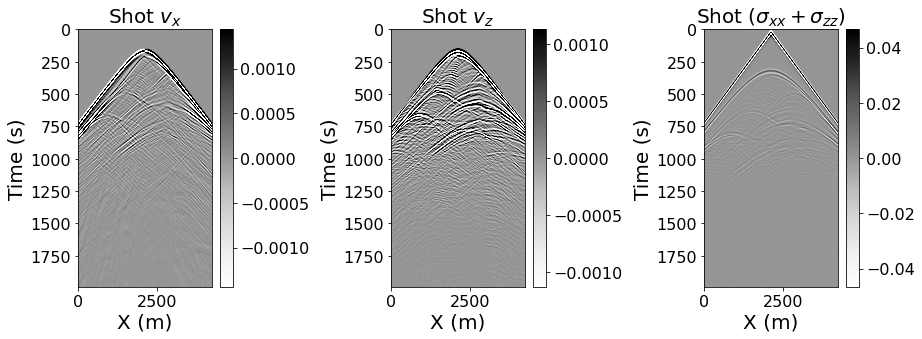

In [55]:
#NBVAL_IGNORE_OUTPUT
slices = [slice(model_marmo.nbl, -model_marmo.nbl), slice(model_marmo.nbl, -model_marmo.nbl)]

aspect_ratio = model_marmo.shape[0]/model_marmo.shape[1]

plt_options_model = {'cmap': 'Greys', 'extent': [model_marmo.origin[0], model_marmo.origin[0] + model_marmo.domain_size[0],
                                               model_marmo.origin[1] + model_marmo.domain_size[1], model_marmo.origin[1]]}
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(13, 5))

scale = np.max(rec_vx.data) /80.

img1 = ax[0].imshow(rec_vx.data, vmin=scale, vmax=-scale, **plt_options_model)
fig.colorbar(img1, ax=ax[0])
ax[0].set_title(r"Shot $v_x$", fontsize=20)
ax[0].set_xlabel('X (m)', fontsize=20)
ax[0].set_ylabel('Time (s)', fontsize=20)
ax[0].set_aspect('auto')

scale2 = np.max(rec_vz.data) /80.
img2 = ax[1].imshow(rec_vz.data, vmin=scale2, vmax=-scale2, **plt_options_model)
fig.colorbar(img2, ax=ax[1])
ax[1].set_title("Shot $v_z$", fontsize=20)
ax[1].set_xlabel('X (m)', fontsize=20)
ax[1].set_ylabel('Time (s)', fontsize=20)
ax[1].set_aspect('auto')

scale3 = np.max(rec_sigma.data) /80.
img3 = ax[2].imshow(rec_sigma.data, vmin=scale3, vmax=-scale3, **plt_options_model)
fig.colorbar(img3, ax=ax[2])
ax[2].set_title(r"Shot ($\sigma_{xx}+\sigma_{zz}$)", fontsize=20)
ax[2].set_xlabel('X (m)', fontsize=20)
ax[2].set_ylabel('Time (s)', fontsize=20)
ax[2].set_aspect('auto')

plt.tight_layout()

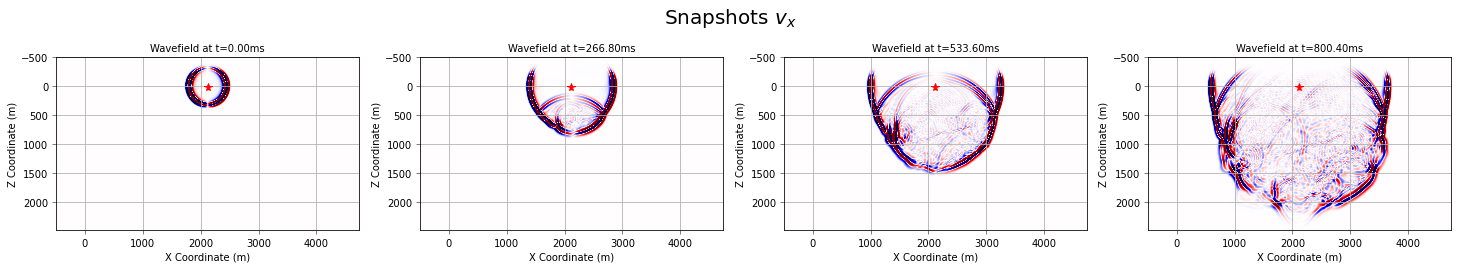

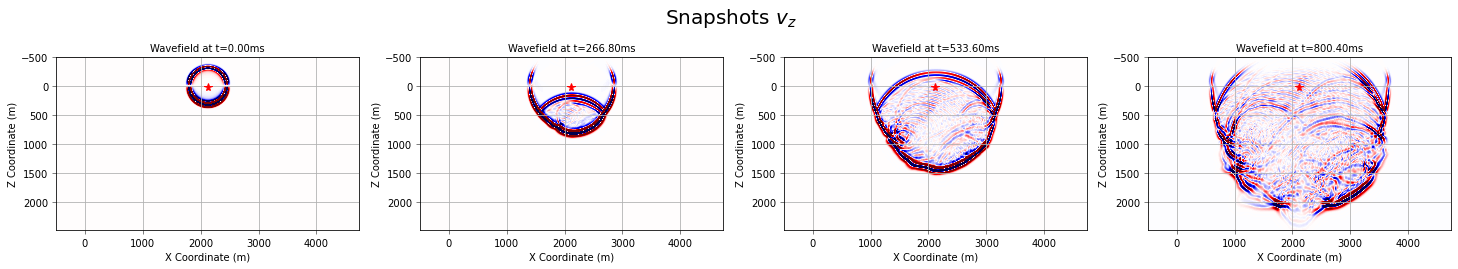

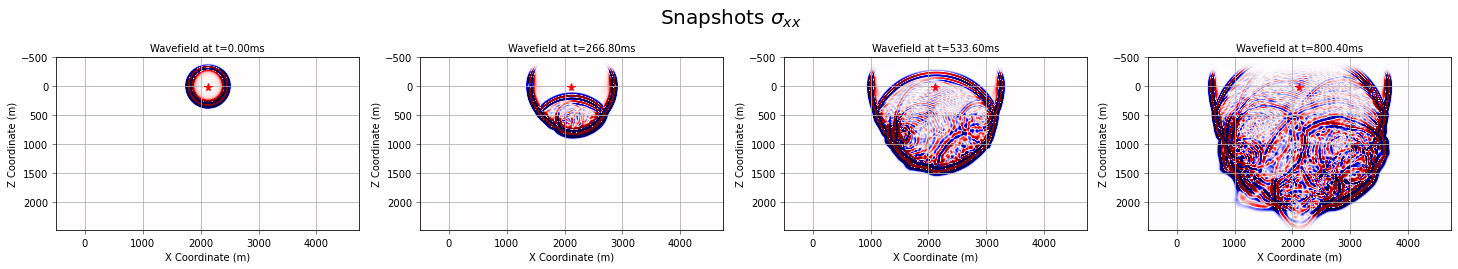

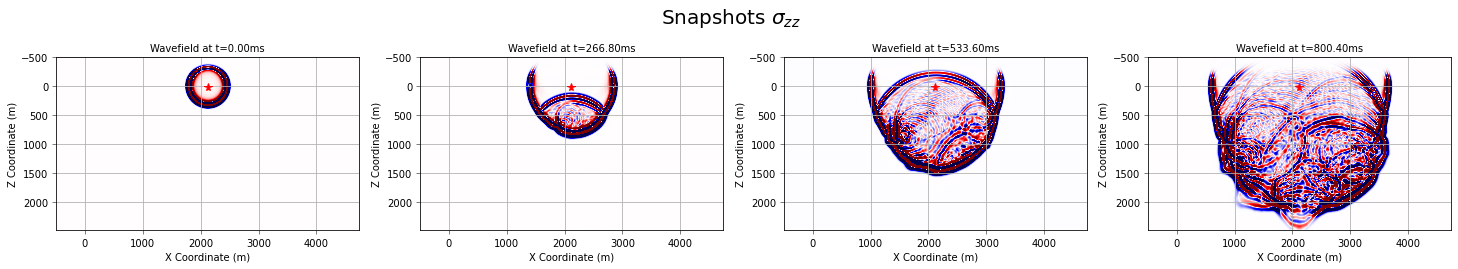

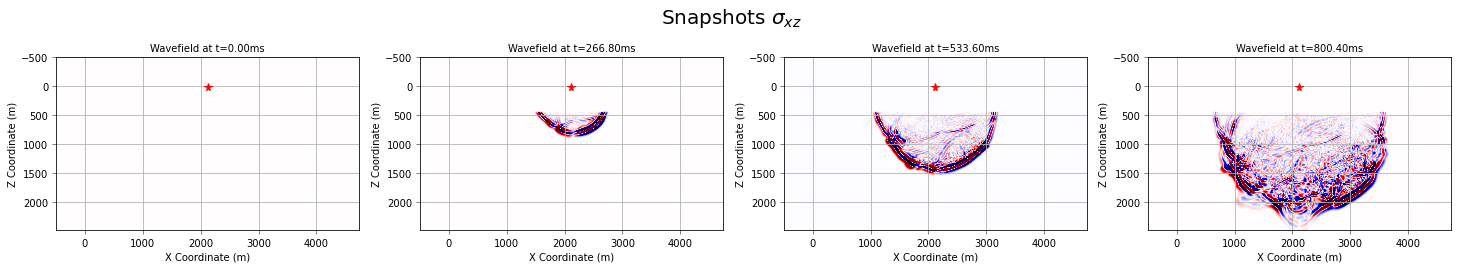

In [65]:
# NBVAL_IGNORE_OUTPUT
# Some useful definitions for plotting if nbl is set to any other value than zero
nxpad,nzpad = shape[0] + 2 * nbl, shape[1] + 2 * nbl
shape_pad   = np.array(shape) + 2 * nbl
origin_pad  = tuple([o - s*nbl for o, s in zip(origin, sp)])
extent_pad  = tuple([s*(n-1) for s, n in zip(sp, shape_pad)])
# Note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin_pad[0], origin_pad[0] + extent_pad[0],
              origin_pad[1] + extent_pad[1], origin_pad[1]]

def plot(a, title=None):
    # Plot the wavefields, each normalized to scaled maximum of last time step
    kt = (time_range.num - 2) - 1
    amax = 1.9 * np.max(np.abs(a.data[kt,:,:]))

    nsnaps = 15
    factor = round(time_range.num/nsnaps)

    fig, axes = plt.subplots(1, 4, figsize=(25, 4), sharex=True)
    fig.suptitle(title, size=20)
    for count, ax in enumerate(axes.ravel()):
        snapshot = factor*(count+1)
        ax.imshow(np.transpose(a.data[snapshot,:,:]), cmap="seismic", vmin=-amax, vmax=+amax, extent=plt_extent)
        ax.plot(model_marmo.domain_size[0]* .5, 10, 'red', linestyle='None', marker='*', markersize=8, label="Source")
        ax.grid()
        ax.tick_params('both', length=4, width=0.5, which='major',labelsize=10)
        ax.set_title("Wavefield at t=%.2fms" % (factor*count*dt),fontsize=10)
        ax.set_xlabel("X Coordinate (m)",fontsize=10)
        ax.set_ylabel("Z Coordinate (m)",fontsize=10)

plot(v[0], title="Snapshots $v_x$ ")
plot(v[1], title="Snapshots $v_z$ ")
plot(sigma[0], title="Snapshots $\sigma_{xx}$")
plot(sigma[1], title="Snapshots $\sigma_{zz}$")
plot(sigma[2], title="Snapshots $\sigma_{xz}$")

# Adjoint elastic equation


Escrevendo no formato matricial como :


\begin{equation}
\left( \begin{array}{cc}\rho \dfrac{\partial}{\partial t} & -D \\
    -C D^{T} & \dfrac{\partial}{\partial t}\end{array}\right) \left(\begin{array}{l}\vec{v} \\ \sigma\end{array}\right)=\left(\begin{array}{c}0 \\ \vec{f}_\sigma\end{array}\right)
\end{equation}

Sendo o sistema :


\begin{equation}
    SW=f,
\end{equation}

Aplicando o método adjunto o sistema anterior torna-se

\begin{equation}
    S^*W^*=f^*,
\end{equation}

transformando o sistema na forma matricial: 


\begin{equation}
    \left(\begin{array}{cc}-\rho \dfrac{\partial}{\partial t} & D C^{T} \\ D^{T} & -\dfrac{\partial}{\partial t}\end{array}\right)\left(\begin{array}{c}\vec{u} \\ \tau\end{array}\right)=\left(\begin{array}{c}0 \\ \Delta \vec{d}\end{array}\right)
\end{equation}

e na forma de sistema de equações: 

\begin{equation}
    \left\{\begin{array}{l}\rho \dfrac{\partial \vec{u}}{\partial t}-D C^{T} \tau=0\\
    D^{T} \vec{u}-\dfrac{\partial \tau}{\partial t}=\Delta\overrightarrow{d}\end{array}\right.
    \label{eq:adjoint_sach}
\end{equation}

  


In [66]:
def elastic_adjoint(u, tau):  
    pde_u = rho * u.dtl - D(C.T*tau)
    u_u = Eq(u.backward, damp * solve(pde_u, u.backward))
    
    pde_tau = -tau.dtl + S(u.backward)
    u_t = Eq(tau.backward, damp * solve(pde_tau, tau.backward))
    
    return [u_u, u_t]

def elastic_no_adjoint(u, tau):
    
    pde_u = rho * u.dtl - D(tau)
    u_u = Eq(u.backward, damp * solve(pde_u, u.backward))
 
    pde_tau = tau.dtl - C*S(u.backward)
    u_t = Eq(tau.backward, damp * solve(pde_tau, tau.backward))
        
    return [u_u, u_t]

In [67]:
def ImagingOperator(model, imf, v, **kwargs):

    u = VectorTimeFunction(name='u', grid=model.grid, space_order=so,
                           time_order=1)
    tau = TensorTimeFunction(name='tau', grid=model.grid, space_order=so,
                             time_order=1)
    tau=tau.vec
    
    kernel = kwargs.get('kernel', "adj")
    
    if kernel=="adj": 
        eqn = elastic_adjoint(u, tau)
    else:
        eqn = elastic_no_adjoint(u, tau)
    

    b = model.b
    # Define residual injection at the location of the forward receivers
    rec_vx = PointSource(name='rec_vx', grid=model.grid,
                         time_range=geometry.time_axis,
                         coordinates=geometry.rec_positions)

    rec_vz = PointSource(name='rec_vz', grid=model.grid,
                         time_range=geometry.time_axis,
                         coordinates=geometry.rec_positions)

    H = VectorFunction(name ="H", grid = model.grid)

    Hx_sum = [Eq(H[0], H[0] + (v[0]**2 ))]
    Hz_sum = [Eq(H[-1], H[-1] + (v[-1]**2 ))]
    H_sum = Hx_sum + Hz_sum  
    
    rec_term_vx = rec_vx.inject(field=u[0].backward, expr=dt*rec_vx*b)
    rec_term_vz = rec_vz.inject(field=u[-1].backward, expr=dt*rec_vz*b)
    
    rec_expr = rec_term_vx + rec_term_vz
    
    ixx_update = [Eq(imf[0], imf[0] + (v[0] * u[0])/(H[0] + 10**(-9)))]
    izz_update = [Eq(imf[-1], imf[-1] + (v[-1] * u[-1])/(H[-1] + 10**(-9)))]
    
    imf_update = ixx_update + izz_update
       
    return Operator(eqn + rec_expr + H_sum + imf_update, subs=model.spacing_map, name='Imaging')


In [72]:
nshots = 20
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = np.linspace(0., model_marmo.shape[0]*model_marmo.spacing[0], num=nshots)
source_locations[:, 1] = 10.

def img_final(model, kernel="adj"):
    
    imf = VectorFunction(name ="imf", grid = model.grid, space_order = 8)

    for i in range(nshots):  
        print('Imaging source %d out of %d' % (i+1, nshots))   
        
        pos = source_locations[i, :]
        rec_vx, rec_vz, rec_sigma, v, sigma = elastic_forward(model, pos)    

        op_imaging = ImagingOperator(model, imf, v, kernel=kernel)
        op_imaging(dt=dt, rec_vx=rec_vx, rec_vz=rec_vz)
        
    return imf


In [73]:
def lapla (model, image):
    lapla = VectorFunction(name='lapla', grid=model.grid, space_order = 8)
    stencil = Eq(lapla, -image.laplace)
    op = Operator([stencil])
    op.apply()
    return lapla

In [74]:
def img(img, model, title=""):
    
    slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]

    aspect_ratio = model.shape[0]/model.shape[1]
    


    plt_options_model = {'cmap': 'Greys', 'extent': [model.origin[0], model.origin[0] + model.domain_size[0],
                                                   model.origin[1] + model.domain_size[1], model.origin[1]]}
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 3.5))

    scale = 0.004 * np.max(img[0].data[slices])
    
    
    np.max(img[0].data[slices]) 

    img1 = ax[0].imshow(np.transpose(img[0].data[slices]), vmin=scale, vmax=-scale, **plt_options_model)
    fig.colorbar(img1, ax=ax[0])
    ax[0].set_title(title + "$v_x$", fontsize=20)
    ax[0].set_xlabel('z (m)', fontsize=20)
    ax[0].set_ylabel('x (m)', fontsize=20)
    ax[0].set_aspect('auto')
    
    scale2 = 0.004 * np.max(img[1].data[slices]) 
    
    img2 = ax[1].imshow(np.transpose(img[1].data[slices]), vmin=scale2, vmax=-scale2, **plt_options_model)
    fig.colorbar(img2, ax=ax[1])
    ax[1].set_title(title + "$v_z$", fontsize=20)
    ax[1].set_xlabel('z (m)', fontsize=20)
    ax[1].set_ylabel('x (m)', fontsize=20)
    ax[1].set_aspect('auto')

In [75]:
imf_adj = img_final(model_marmo)

Imaging source 1 out of 20
Imaging source 2 out of 20
Imaging source 3 out of 20
Imaging source 4 out of 20
Imaging source 5 out of 20
Imaging source 6 out of 20
Imaging source 7 out of 20
Imaging source 8 out of 20
Imaging source 9 out of 20
Imaging source 10 out of 20
Imaging source 11 out of 20
Imaging source 12 out of 20
Imaging source 13 out of 20
Imaging source 14 out of 20
Imaging source 15 out of 20
Imaging source 16 out of 20
Imaging source 17 out of 20
Imaging source 18 out of 20
Imaging source 19 out of 20
Imaging source 20 out of 20


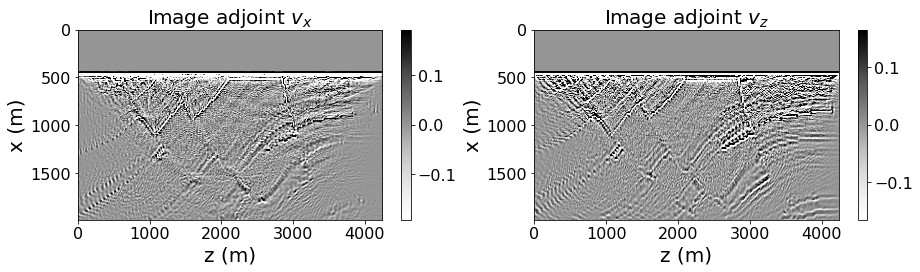

In [76]:
# Applying laplacian filter

image_final_adj = lapla(model_marmo, imf_adj)

# Doing zero the water layer 

image_final_adj[0].data[:, :95] = 0.
image_final_adj[1].data[:, :95] = 0.

img(image_final_adj, model_marmo, title= "Image adjoint ")